# Part 1: Action Log Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly
from dateutil.relativedelta import relativedelta
import seaborn as sns
from collections import defaultdict

In [2]:
transaction = pd.read_csv('Transactions.csv')
channels = pd.read_csv('Channels.csv')

In [3]:
transaction.isna().sum()

UserID           0
Date             0
Time             0
Paid Amount      0
ChannelID      204
dtype: int64

## preprocessing

In [4]:
import jdatetime
import datetime

transaction['ShamsiDate'] = transaction['Date'].apply(lambda x: jdatetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
# convert to jalali
transaction['Date'] = transaction['ShamsiDate'].apply(lambda x: jdatetime.date.togregorian(x))
# convert date to datetime
transaction['Date'] = transaction['Date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y-%m-%d'))

transaction['Time'] = transaction['Time'].apply(lambda x: str(x).zfill(6))
transaction['DateTime'] = transaction['Date'] + transaction['Time']\
.apply(lambda x: datetime.timedelta(hours=int(str(x)[:2]), minutes=int(str(x)[2:4]), seconds=int(str(x)[4:])))

del transaction['Date']
del transaction['Time']

transaction

,UserID,Paid Amount,ChannelID,ShamsiDate,DateTime
0,37087,623100,1.0,1398-03-24,2019-06-14 21:03:41
1,88681,420000,2.0,1398-01-04,2019-03-24 01:06:17
2,3617,390000,3.0,1398-01-13,2019-04-02 22:30:52
3,111638,3375000,4.0,1398-03-05,2019-05-26 17:16:49
4,2216,660000,5.0,1398-03-15,2019-06-05 22:22:11
...,...,...,...,...,...
206659,15893,660000,10.0,1398-08-22,2019-11-13 17:00:30
206660,15893,660000,10.0,1398-04-19,2019-07-10 14:19:38
206661,15893,561000,10.0,1398-08-22,2019-11-13 16:56:13
206662,15893,660000,10.0,1398-07-11,2019-10-03 12:58:26


## Metrics

### 1)

In [5]:
last_date = transaction['DateTime'].max()
transaction_3_months = transaction[transaction['DateTime'] >= last_date - pd.Timedelta(days=90)]

transactions_per_day =  transaction_3_months.groupby(by=transaction_3_months['DateTime'].dt.date)

transactions_per_day_count = transactions_per_day.count()
transactions_per_day_sum = transactions_per_day.sum()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(transactions_per_day_count.index), y=list(transactions_per_day_count['UserID'])))
fig.update_layout(title_text="Number of Transactions")
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Number of Transactions")
fig.update_xaxes(calendar='jalali', tickformat="%b\n\n\n%Y")
fig.show()

# sum of each day
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(transactions_per_day_sum.index), y=list(transactions_per_day_sum['Paid Amount'])))
fig.update_layout(title_text="Sum of Transactions")
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Sum of Transactions (Rials)")
fig.update_xaxes(calendar='jalali', tickformat="%b\n\n\n%Y")

### 2)

In [6]:
# sum and count of last 48 hours
transaction_48_hours = transaction_3_months[transaction_3_months['DateTime'] >= last_date - pd.Timedelta(hours=48)]
# groupby date and hours
transactions_per_days_and_hours = transaction_48_hours.groupby(by=[transaction_48_hours['DateTime'].dt.date, transaction_48_hours['DateTime'].dt.hour])

transactions_per_hours_count = transactions_per_days_and_hours.count()
transactions_per_hours_sum = transactions_per_days_and_hours.sum()

multi_index = list(transactions_per_hours_count.index)
index = list(map(lambda x: pd.to_datetime(x[0]) + datetime.timedelta(hours=x[1]), multi_index))
transactions_per_hours_count.index = index

multi_index = list(transactions_per_hours_sum.index)
index = list(map(lambda x: pd.to_datetime(x[0]) + datetime.timedelta(hours=x[1]), multi_index))
transactions_per_hours_sum.index = index

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(transactions_per_hours_count.index), y=list(transactions_per_hours_count['UserID'])))
fig.update_layout(title_text="Number of Transactions")
fig.update_xaxes(title_text="Month,Day,Hour")
fig.update_yaxes(title_text="Number of Transactions")
fig.update_xaxes(calendar='jalali', tickformat="%b,%d,%H")
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(transactions_per_hours_sum.index), y=list(transactions_per_hours_sum['Paid Amount'])))
fig.update_layout(title_text="Sum of Transactions")
fig.update_xaxes(title_text="Month,Day,Hour")
fig.update_yaxes(title_text="Sum of Transactions (Rials)")
fig.update_xaxes(calendar='jalali', tickformat="%b,%d,%H\n\n\n%Y")
fig.show()

### 3)

In [7]:
transactions_per_month = transaction.groupby(by=[transaction['DateTime'].dt.year, transaction['DateTime'].dt.month])

distinct_users_per_month = transactions_per_month['UserID'].nunique()

multi_index = list(distinct_users_per_month.index)
index = list(map(lambda x: datetime.date(year=x[0], month=x[1], day=1), multi_index))
distinct_users_per_month.index = index


fig = go.Figure()
fig.add_trace(go.Scatter(x=list(distinct_users_per_month.index), y=list(distinct_users_per_month)))
fig.update_layout(title_text="Number of Users in each Month")
fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="Number of Users")
fig.update_xaxes(calendar='jalali', tickformat="%b\n\n\n%Y")
fig.show()

### 4)

In [8]:
transaction['revenue'] = transaction['Paid Amount'] * 0.1

# groupby week
transactions_per_week = transaction.groupby(by=[transaction['DateTime'].dt.year, transaction['DateTime'].dt.month, pd.Grouper(key='DateTime', freq='W-Sun')])

# sum revenue
transactions_per_week_sum = transactions_per_week['revenue'].sum()
transactions_per_week_sum
multi_index = list(transactions_per_week_sum.index)
index = list(map(lambda x: x[2], multi_index))
transactions_per_week_sum.index = index

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(transactions_per_week_sum.index), y=list(transactions_per_week_sum)))
fig.update_layout(title_text="Sum of Revenue")
fig.update_xaxes(title_text="Month,Day")
fig.update_yaxes(title_text="Sum of Revenue (Rials)")
fig.update_xaxes(calendar='jalali', tickformat="%b,%d\n\n\n%Y")

### 5)

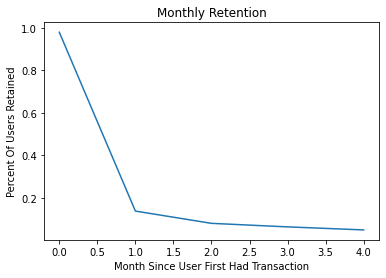

In [9]:
first_transaction = transaction.groupby('UserID')['DateTime'].min()
df = pd.merge(transaction, first_transaction, on='UserID', how='left', suffixes=('_t', '_ft'))

df['months_from_ft'] = np.floor((df['DateTime_t'] - df['DateTime_ft'].values.astype('datetime64[M]'))/np.timedelta64(1, 'M'))

retention = df.groupby('months_from_ft')['UserID'].nunique().head() / df['UserID'].nunique()

plt.plot(retention)
plt.title("Monthly Retention")
plt.xlabel("Month Since User First Had Transaction")
plt.ylabel("Percent Of Users Retained");

### 6)

In [10]:
df = transaction.copy() 
df['months'] = df['DateTime'].apply(lambda x: datetime.date(x.year, x.month,1))
df['ft'] = df.groupby('UserID')['months'].transform('min')

def diff_month(x):
    d1 = x['months']
    d2 = x["ft"]
    return ((d1.year - d2.year) * 12 + d1.month - d2.month)+1

df['cohort_idx'] = df.apply(lambda x: diff_month(x), axis=1)

cd = df.groupby(['ft', 'cohort_idx'])['UserID'].apply(pd.Series.nunique).reset_index()
cc = cd.pivot_table(index = 'ft', columns = 'cohort_idx', values = 'UserID')
cs = cc.iloc[:,0]

retention = cc.divide(cs, axis = 0)
retention = retention.round(3) * 100
retention

cohort_idx,1,2,3,4,5,6,7,8,9,10,11,12,13
ft,,,,,,,,,,,,,
2019-03-01,100.0,11.6,6.9,9.1,8.2,7.1,7.7,4.7,4.1,2.5,3.5,3.3,1.0
2019-04-01,100.0,15.4,13.5,11.6,9.0,9.0,6.2,5.2,3.8,5.0,4.3,1.2,NaN
2019-05-01,100.0,17.7,14.4,11.2,9.8,6.9,5.5,4.4,5.0,4.9,1.2,NaN,NaN
2019-06-01,100.0,15.7,10.5,9.3,6.4,5.1,3.7,4.4,4.0,1.0,NaN,NaN,NaN
2019-07-01,100.0,13.4,10.2,6.0,4.7,3.8,4.3,4.1,0.9,NaN,NaN,NaN,NaN
2019-08-01,100.0,12.9,6.5,5.6,3.7,4.7,4.2,1.3,NaN,NaN,NaN,NaN,NaN
2019-09-01,100.0,10.0,6.8,5.2,5.9,4.9,1.1,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-01,100.0,10.3,6.8,6.6,6.2,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-01,100.0,9.4,7.9,6.4,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


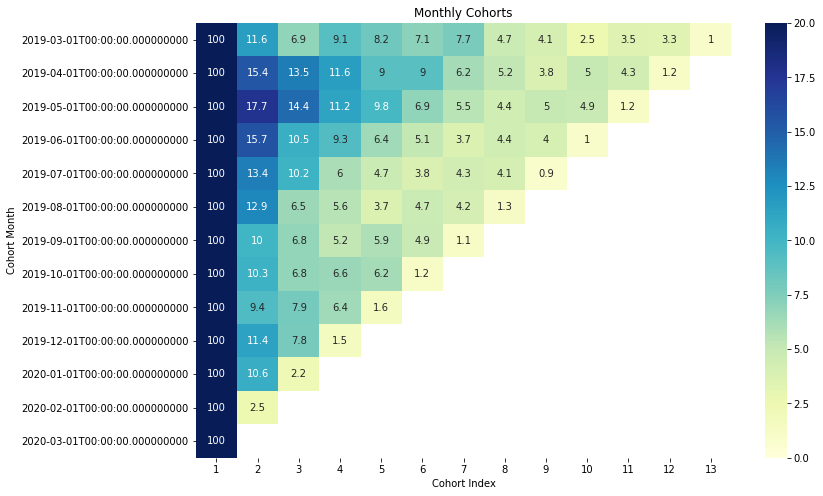

In [11]:
plt.figure(figsize=(12, 8))
plt.title('Monthly Cohorts')
sns.heatmap(retention, annot = True,vmin = 0.0, vmax =20,cmap="YlGnBu", fmt='g')
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()

In [12]:
df = transaction.copy().dropna()

first_transactions_index = df.groupby('UserID')['DateTime'].idxmin()
not_first_transactions = df.loc[~df.index.isin(first_transactions_index)]


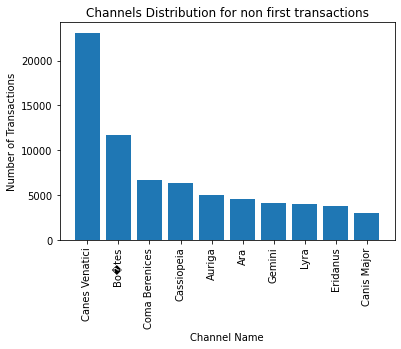

In [13]:
channels_dists = not_first_transactions['ChannelID'].value_counts().sort_values(ascending=False).iloc[:10]

channels_dists = pd.merge(channels_dists, channels, left_index=True, right_index=True)

plt.bar(channels_dists['ChannelName'], channels_dists['ChannelID_x'])
plt.title('Channels Distribution for non first transactions')
plt.xlabel('Channel Name')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=90);

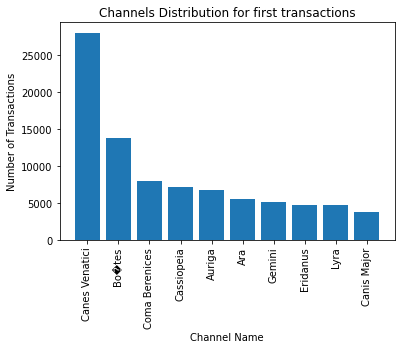

In [14]:
first_transactions = df.loc[df.index.isin(first_transactions_index)]
channels_dists = first_transactions['ChannelID'].value_counts().sort_values(ascending=False).iloc[:10]

channels_dists = pd.merge(channels_dists, channels, left_index=True, right_index=True)

plt.bar(channels_dists['ChannelName'], channels_dists['ChannelID_x'])
plt.title('Channels Distribution for first transactions')
plt.xlabel('Channel Name')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=90);


In [15]:
df = transaction.copy()
df = pd.merge(df, channels)

In [16]:
two_first_transactions_index = df.groupby('UserID')['DateTime'].nsmallest(2).index

In [17]:
users_default_dict = defaultdict(list)
for multi_index in two_first_transactions_index:
    user_id = multi_index[0]
    users_default_dict[user_id].append(multi_index[1])

users_default_dict = {k: v for k, v in users_default_dict.items() if len(v) == 2}

channels_names = channels['ChannelName'].tolist()

df_channels = pd.DataFrame(index=channels_names, columns=channels_names)
df_channels.fillna(0, inplace=True)

for user, transaction_index in users_default_dict.items():
    
    first_channel = df.loc[transaction_index[0], 'ChannelName']
    second_channel = df.loc[transaction_index[1], 'ChannelName']

    df_channels.loc[first_channel, second_channel] += 1

df_channels

,Antlia,Ara,Aries,Auriga,Bo�tes,Canes Venatici,Canis Major,Cassiopeia,Cetus,Chamaeleon,...,Phoenix,Sagitta,Sagittarius,Scorpius,Serpens,Taurus,Triangulum,Ursa Major,Vela,Virgo
Antlia,1409,11,49,72,151,12,42,1,3,36,...,1,1,1,6,2,0,0,0,0,0
Ara,7,479,16,31,40,7,11,1,1,12,...,1,1,0,0,0,0,0,0,0,0
Aries,35,26,1429,121,230,19,59,5,8,68,...,3,6,5,4,0,1,0,1,0,0
Auriga,53,33,109,3554,397,44,93,6,7,67,...,4,8,3,9,4,0,2,0,0,0
Bo�tes,156,62,215,392,7716,98,197,5,17,207,...,13,11,6,19,4,0,0,0,0,0
Canes Venatici,10,10,24,60,100,979,26,0,3,23,...,0,1,0,1,0,1,0,0,0,0
Canis Major,38,15,69,118,188,22,1831,4,1,52,...,5,6,3,7,1,0,1,0,0,0
Cassiopeia,0,1,4,8,8,0,3,99,0,0,...,0,0,0,1,0,0,0,0,0,0
Cetus,5,1,1,10,12,0,3,0,145,6,...,0,0,0,0,0,0,0,0,0,0
Chamaeleon,33,15,51,99,196,18,50,2,6,2094,...,6,3,3,6,1,0,0,0,0,0


<AxesSubplot:>

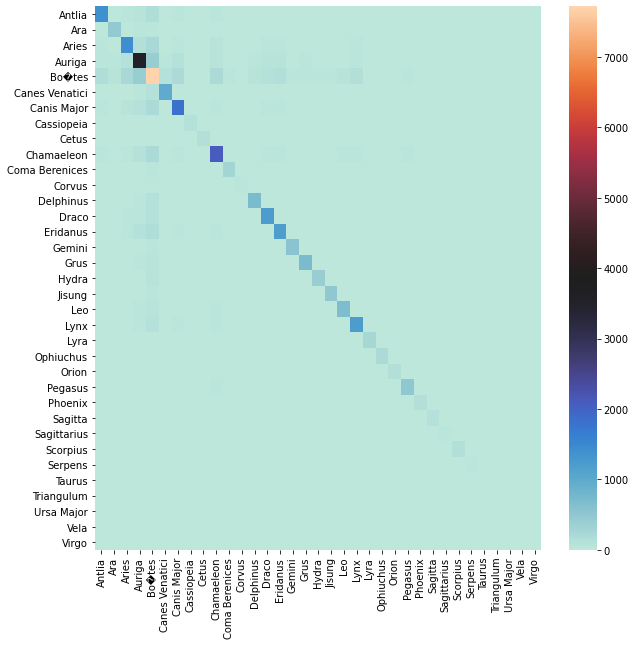

In [51]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_channels, cmap="icefire")